<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/Ejercicios/Ejercicio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 2. Entrenamiento de modelos de clasificación con Keras

En este segundo ejercicio tendrás que trabajar con Keras para probar las técnicas que has visto hasta la Práctica 5.2, incluyendo regularización (L2, dropout, data augmentation, K-validación cruzada, etc.), capas convolucionales, pooling, densas, etc. con **al menos 4 configuraciones** distintas. Además, emplearás tu modelo con tu webcam.

Para ello, vas a tener que trabajar con un conjunto de datos sobre imágenes de personas que llevan o no máscara. 

![mask](https://github.com/miguelamda/DL/blob/master/Ejercicios/img/mask.jpg?raw=1)

## 1. Enunciado

Empleando el dataset de mascarillas (ver apartado 3), debes construir y probar **al menos 4** configuraciones de modelos con Keras que sean sustancialmente distintas. Debes jugar con:
* K-validación y validación cruzada.
* Regularización: L1/L2, early stopping, dropout.
* Data augmentation: echando un vistazo al dataset, ¿qué tipo de transformación harías? ¿qué transformaciones NO harías? ¿qué ventaja se obtiene al usar aumentado?.
* Distintas arquitecturas de redes convolucionales: distinta cantidad y orden de capas convolucionales, pooling, densas, etc.
* Distintos optimizadores (Adam, RMSprop, momentum, etc.), factor de aprendizaje y número de épocas.
* Inicialización aleatoria de pesos (Normal, Xavier, Glorot, He).

Detalla cada configuración (arquitectura de red, hiperparámetros, etc), explicando brevemente cada componente empleada (cuando se use por primera vez en este trabajo, por ejemplo, cuando se use regularización L2, hay que explicar brevemente qué es), y haciendo uso de imágenes y figuras para representar la arquitectura de la red.

Después, entrénalas con los datos leídos y analiza los resultados, haciendo una comparativa y razonando lo obtenido.

## 2. Entrega

La entrega de este ejercicio se realiza a través de la tarea creada para tal efecto en Enseñanza Virtual. Tienes que entregar un notebook, y el HTML generado a partir de él, cuyas celdas estén ya evaluadas.

La estructura del notebook debe contener los siguientes apartados:

0. Cabecera: nombre y apellidos.
1. Dataset: descripción, carga y visualización.
2. Preparación de los datos para ser usados en Keras.
3. Modelos y configuraciones creados en Keras (un sub-apartado para cada uno, explicando de forma razonada, con tus palabras y figuras, la arquitectura probada).
4. Entrenamiento y evaluación de cada modelo creado (un sub-apartado para cada uno).
5. Análisis de resultados.
6. Bibliografía utilizada (enlaces web, material de clase, libros, etc.).

### 2.1. Nota importante
-----
**HONESTIDAD ACADÉMICA Y COPIAS: un trabajo práctico es un examen, por lo que
debe realizarse de manera individual. La discusión y el intercambio de
información de carácter general con los compañeros se permite (e incluso se
recomienda), pero NO AL NIVEL DE CÓDIGO. Igualmente el remitir código de
terceros, OBTENIDO A TRAVÉS DE LA RED o cualquier otro medio, se considerará
plagio.** 

**Cualquier plagio o compartición de código que se detecte significará
automáticamente la calificación de CERO EN LA ASIGNATURA para TODOS los
alumnos involucrados. Por tanto a estos alumnos NO se les conservará, para
futuras convocatorias, ninguna nota que hubiesen obtenido hasta el momento.
SIN PERJUICIO DE OTRAS MEDIDAS DE CARÁCTER DISCIPLINARIO QUE SE PUDIERAN
TOMAR.**

-----

## 3. El Dataset: Mask Dataset <a class="anchor" id="transferdata"></a>

Este pequeño dataset está disponible en Kaggle. Es una versión reducida del construido en [este tutorial](https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/). La pandemia originada por el SARS-Cov2 ha propiciado la creación de diversos datasets para detectar si las personas están llevando mascarilla o no. En este dataset para este ejeercicio, tenemos imágenes de personas con y sin mascarilla (algunas se les ha puesto la mascarilla de forma "artificial"). El enlace al dataset es el siguiente [Face Mask Detection](https://www.kaggle.com/omkargurav/face-mask-dataset). Si no tienes cuenta en Kaggle, o si quieres ir más rápido, puedes ejecutar la siguiente celda. Descargará el dataset directamente en tu sesión/ordenador desde un enlace directo.

After downloading the dataset from kaggle, I put it in the same directory of this code in a directory named "data". In that directory there are two sub-directory, one for images with_mask and one for without_mask ones. I need to split this data in train, validation and test set, i will create a new directory "mask_ds" splitting the dataset in three subfolders like this: 60%-20%-20%. In these cases i prefer to define a more general function that iterates the process for every category (in this case with_mask and without_mask).

In [1]:
import os
import random
import shutil

def split_dataset(source_dir, dest_dir, train_percent, validation_percent, test_percent):
    
    train_dir = os.path.join(dest_dir, 'train')
    validation_dir = os.path.join(dest_dir, 'validation')
    test_dir = os.path.join(dest_dir, 'test')
    
    if os.path.exists(dest_dir):
        return (train_dir, validation_dir, test_dir)
    
    os.mkdir(dest_dir)
    
    if not os.path.exists(train_dir):
        os.mkdir(train_dir)

    if not os.path.exists(validation_dir):
        os.mkdir(validation_dir)

    if not os.path.exists(test_dir):
        os.mkdir(test_dir)
    
    categories = os.listdir(source_dir)

    for category in categories:
        category_source_dir = os.path.join(source_dir, category)
        category_dest_train_dir = os.path.join(train_dir, category)
        category_dest_validation_dir = os.path.join(validation_dir, category)
        category_dest_test_dir = os.path.join(test_dir, category)

        if not os.path.exists(category_dest_train_dir):
            os.mkdir(category_dest_train_dir)

        if not os.path.exists(category_dest_validation_dir):
            os.mkdir(category_dest_validation_dir)

        if not os.path.exists(category_dest_test_dir):
            os.mkdir(category_dest_test_dir)

        files = os.listdir(category_source_dir)
        random.shuffle(files)

        num_files = len(files)
        num_train = int(num_files * train_percent)
        num_validation = int(num_files * validation_percent)

        train_files = files[:num_train]
        validation_files = files[num_train:num_train + num_validation]
        test_files = files[num_train + num_validation:]

        for file in train_files:
            src = os.path.join(category_source_dir, file)
            dst = os.path.join(category_dest_train_dir, file)
            shutil.copyfile(src, dst)
            
        for file in validation_files:
            src = os.path.join(category_source_dir, file)
            dst = os.path.join(category_dest_validation_dir, file)
            shutil.copyfile(src, dst)

        for file in test_files:
            src = os.path.join(category_source_dir, file)
            dst = os.path.join(category_dest_test_dir, file)
            shutil.copyfile(src, dst)

    return train_dir, validation_dir, test_dir


In [3]:
source_directory = 'data'
destination_directory = 'mask_ds'
train_dir,validation_dir,test_dir= split_dataset(source_directory, destination_directory,0.6,0.2,0.2)

We can now load our images in the folders with ImageDataGenerator, scaling them for setting the values between 0 and 1.

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=20,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=20,
    class_mode='binary'
)

Found 4531 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [7]:
class_indices_train = train_generator.class_indices
print("Mapping tra nomi di classi ed etichette numeriche (addestramento):", class_indices_train)

Mapping tra nomi di classi ed etichette numeriche (addestramento): {'with_mask': 0, 'without_mask': 1}


Let's start building a model with 2 convolutional layers with 3x3 filters followed by 2x2 max-pooling, a flatten layer for vectorizing the images and two fully connected layers, the last one has sigmoid as activation function since it's binary classification.

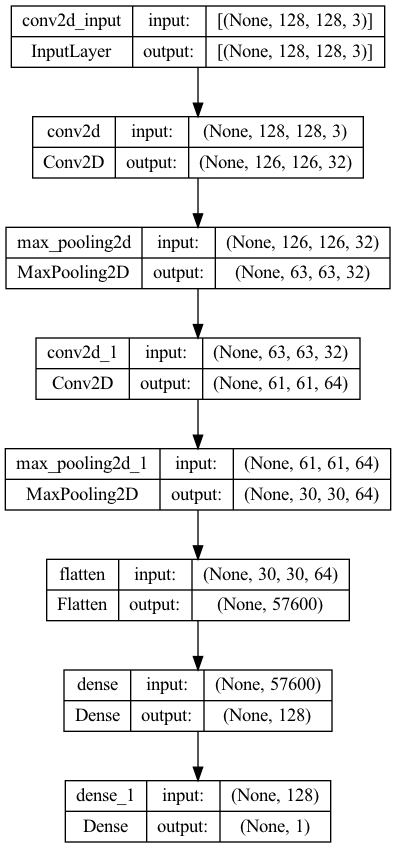

In [5]:
from tensorflow import keras
from keras import layers
from keras import models
from keras.utils.vis_utils import plot_model

model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

plot_model(model, to_file='CNN_mask_plot.png', show_shapes=True, show_layer_names=True)


In [6]:
history = model.fit(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=10,
      validation_data=val_generator,
      validation_steps=len(val_generator))

Epoch 1/10


2024-01-19 17:27:13.054060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-01-19 17:27:13.075566: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


227/227 [==============================] - ETA: 0s - loss: 0.4463 - accuracy: 0.8159

2024-01-19 17:27:28.802549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/Users/antoniopace/anaconda3/lib/python3.11/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


227/227 [==============================] - 18s 80ms/step - loss: 0.4463 - accuracy: 0.8159 - val_loss: 0.2966 - val_accuracy: 0.8775
Epoch 2/10
227/227 [==============================] - 18s 78ms/step - loss: 0.2492 - accuracy: 0.9029 - val_loss: 0.2430 - val_accuracy: 0.8987
Epoch 3/10
227/227 [==============================] - 18s 80ms/step - loss: 0.1947 - accuracy: 0.9247 - val_loss: 0.2920 - val_accuracy: 0.9020
Epoch 4/10
227/227 [==============================] - 18s 81ms/step - loss: 0.1360 - accuracy: 0.9506 - val_loss: 0.2563 - val_accuracy: 0.9079
Epoch 5/10
184/227 [=======================>......] - ETA: 2s - loss: 0.0760 - accuracy: 0.9728

KeyboardInterrupt: 

In [8]:

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=20,
    class_mode='binary'
)

test_evaluation_result = model.evaluate(test_generator)
train_evaluation_result = model.evaluate(train_generator)

print("Test evaluation result: ", test_evaluation_result[1])
print("Train evaluation result: ", train_evaluation_result[1])


Found 1512 images belonging to 2 classes.


Evaluating the model, we can notice a 91.7% accuracy on the test set which is not bad, but a 100% accuracy on the train set that can indicate a problem of overfitting. For solving this problem we can start adding a Dropout, setting to zero some neurons on the layers in the feed forward propagation with a probability p.

In [ ]:
model2 = keras.Sequential()

model2.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model2.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model2.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model2.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model2.add(keras.layers.Flatten())

model2.add(keras.layers.Dense(128, activation='relu'))
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

plot_model(model2, to_file='CNN_mask_plot2.png', show_shapes=True, show_layer_names=True)

In [ ]:
history2 = model2.fit(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=10,
      validation_data=val_generator,
      validation_steps=len(val_generator))

In [ ]:
test_evaluation_result = model2.evaluate(test_generator)
train_evaluation_result = model2.evaluate(train_generator)

print("Test evaluation result: ", test_evaluation_result[1])
print("Train evaluation result: ", train_evaluation_result[1])


We don't have 100% accuracy on the train set anymore but still there is overfitting. Other methods that we can use for preventing it are the L2 regularization and the early stopping.

The L2 regularization is also called "ridge" and it's a technique that adds a penalty term to the loss, based on the squared sum of the weights. This is for decrease the importance of the weights when there is too much overfitting.

Since we're using all those techniques for mitigate the overfitting, we can also increase the number of epochs for a better training phase.

In [ ]:
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model3 = keras.Sequential()

model3.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model3.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model3.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model3.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model3.add(keras.layers.Flatten())

model3.add(keras.layers.Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
model3.add(keras.layers.Dropout(0.2))

model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

plot_model(model3, to_file='CNN_mask_plot3.png', show_shapes=True, show_layer_names=True)

In [ ]:
history3 = model3.fit(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=20,
      validation_data=val_generator,
      validation_steps=len(val_generator),
      callbacks=[early_stopping])

We can notice that the early stopping didn't hit because it only stops the training when the error on the validation sets grows for #patience (3 in this case) epochs.

In [ ]:
test_evaluation_result = model3.evaluate(test_generator)
train_evaluation_result = model3.evaluate(train_generator)

print("Test evaluation result: ", test_evaluation_result[1])
print("Train evaluation result: ", train_evaluation_result[1])

Another way to improve our model and reduce the overfitting is with data augmentation. Applying some trasformations to the images we can enlarge our dataset and avoid that in the training phase the model sees the same identical image multiple times.

I tried to avoid transformations like the vertical flip and big rotation values since cam images automatically rotates the image and we usually don't have vertical flipped images of people.

Obviously the transformations will be done only on the training set and not on the validation and test set.

In [12]:
train_datagen2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator2 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary'
)

val_generator2 = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary'
)

Found 4531 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


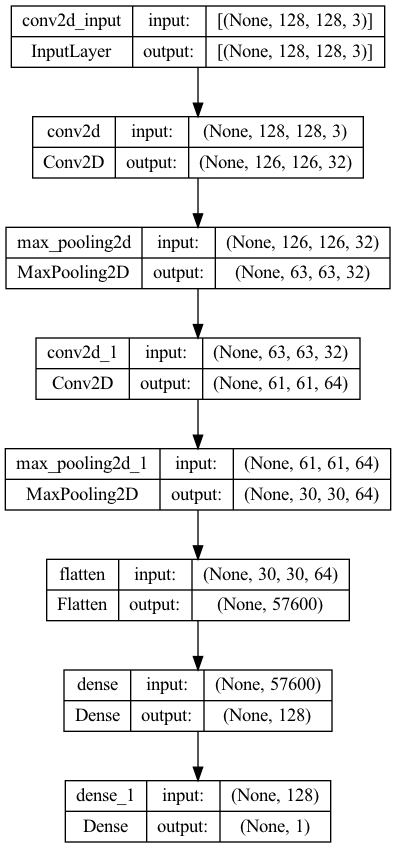

In [14]:
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

early_stopping2 = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

model4 = keras.Sequential()

model4.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model4.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model4.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model4.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model4.add(keras.layers.Flatten())

model4.add(keras.layers.Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
model4.add(keras.layers.Dropout(0.2))

model4.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=l2(0.01)))
model4.add(keras.layers.Dropout(0.2))

model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

plot_model(model, to_file='CNN_mask_plot4.png', show_shapes=True, show_layer_names=True)

In [ ]:
history4 = model4.fit(
      train_generator2,
      steps_per_epoch=len(train_generator2),
      epochs=40,
      validation_data=val_generator2,
      validation_steps=len(val_generator2),
      callbacks = [early_stopping2])

In [ ]:
test_evaluation_result = model4.evaluate(test_generator)
train_evaluation_result = model4.evaluate(train_generator)

print("Test evaluation result: ", test_evaluation_result[1])
print("Train evaluation result: ", train_evaluation_result[1])

Let's add some layers and remove the dropout on one layer, since that with data augmentation we have reached enough prevention against the overfitting.

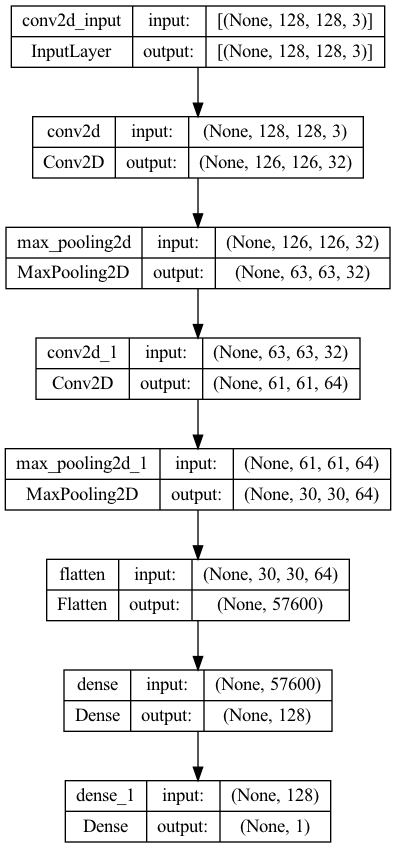

In [15]:
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

model5 = keras.Sequential()

model5.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model5.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model5.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model5.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model5.add(keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
model5.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model5.add(keras.layers.Flatten())

model5.add(keras.layers.Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
model5.add(keras.layers.Dropout(0.2))

model5.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=l2(0.01)))

model5.add(keras.layers.Dense(32, activation='relu',kernel_regularizer=l2(0.01)))

model5.add(keras.layers.Dense(1, activation='sigmoid'))

model5.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

plot_model(model, to_file='CNN_mask_plot5.png', show_shapes=True, show_layer_names=True)

In [16]:
history5 = model5.fit(
      train_generator2,
      steps_per_epoch=len(train_generator2),
      epochs=40,
      validation_data=val_generator2,
      validation_steps=len(val_generator2),
      callbacks = [early_stopping2])

Epoch 1/40


2024-01-19 18:08:28.744705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-01-19 18:08:28.749692: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


284/284 [==============================] - ETA: 0s - loss: 1.0262 - accuracy: 0.7455

2024-01-19 18:08:54.024389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/Users/antoniopace/anaconda3/lib/python3.11/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


284/284 [==============================] - 29s 100ms/step - loss: 1.0262 - accuracy: 0.7455 - val_loss: 0.5413 - val_accuracy: 0.8291
Epoch 2/40
284/284 [==============================] - 29s 101ms/step - loss: 0.5348 - accuracy: 0.8131 - val_loss: 0.4037 - val_accuracy: 0.8530
Epoch 3/40
284/284 [==============================] - 29s 104ms/step - loss: 0.4668 - accuracy: 0.8318 - val_loss: 0.3286 - val_accuracy: 0.9020
Epoch 4/40
284/284 [==============================] - 29s 102ms/step - loss: 0.4111 - accuracy: 0.8621 - val_loss: 0.2964 - val_accuracy: 0.9172
Epoch 5/40
284/284 [==============================] - 28s 99ms/step - loss: 0.3956 - accuracy: 0.8704 - val_loss: 0.3919 - val_accuracy: 0.8583
Epoch 6/40
284/284 [==============================] - 29s 103ms/step - loss: 0.3734 - accuracy: 0.8795 - val_loss: 0.2747 - val_accuracy: 0.9311
Epoch 7/40
284/284 [==============================] - 29s 100ms/step - loss: 0.3527 - accuracy: 0.8850 - val_loss: 0.4818 - val_accuracy: 0.82

In [17]:
test_evaluation_result = model5.evaluate(test_generator)
train_evaluation_result = model5.evaluate(train_generator)

print("Test evaluation result: ", test_evaluation_result[1])
print("Train evaluation result: ", train_evaluation_result[1])

 2/76 [..............................] - ETA: 5s - loss: 0.1140 - accuracy: 0.9750

2024-01-19 18:27:24.741336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


  5/227 [..............................] - ETA: 6s - loss: 0.1770 - accuracy: 0.9500

2024-01-19 18:27:27.592708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 9s 38ms/step - loss: 0.1511 - accuracy: 0.9636
Test evaluation result:  0.9616402387619019
Train evaluation result:  0.9635841846466064


In [ ]:
model5.predict(test_generator)

We have reached a good accuracy and there is no overfitting.

# 4.3 Evaluando el modelo

La siguiente celda debería permitirte cargar un modelo guardado en la variable `model`, y usarlo para hacer predicción con la imagen capturada.

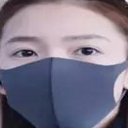

In [18]:
from PIL import Image
import base64
from numpy import asarray
import io
import numpy as np
import time

pil_im = pil_im = Image.open("with_mask_16.jpg") # versión en local
#pil_im = Image.open(filename)  # versión en google colab
pil_im = pil_im.convert('RGB')
pil_im = pil_im.resize((128,128))
pil_im

In [24]:
im = np.asarray(pil_im) / 255
print(model5.predict(np.array([im])))  # Muestra la salida del modelo y el resultado (con o sin mascarilla)
result = 'con mascarilla' if model5.predict(np.array([im])) <= 0.5 else 'sin mascarilla'
print(result)

1/1 [==============================] - 0s 21ms/step
[[0.00278748]]
1/1 [==============================] - 0s 16ms/step
con mascarilla


The model evaluates the example correctly.